In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
from google.colab import drive
from PIL import Image
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization, Input, Conv3D, MaxPool3D, ConvLSTM2D, Permute, Conv2D, LeakyReLU
from tensorflow.keras import backend as kb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import io
import pandas as pd


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dataset

local_download_path = os.path.expanduser('/content/drive/My Drive/Images')
img = []
for filename in os.listdir(local_download_path): 
  for images in os.listdir(os.path.join(local_download_path,filename)):
    temp = Image.open(os.path.join(os.path.join(local_download_path,filename),images))
    temp = temp.convert('L')
    img.append([images,temp])

img.sort() 


In [0]:
# input image dimensions

input_x = 64
input_y = 64
output_x = 64
output_y = 64


In [0]:
dataset = []
labels = []

for i in range(len(img)):
    dataset.append(np.array(img[i][1].resize((input_x,input_y))))
    labels.append(np.array(img[i][1].resize((output_x,output_y))))
# Take the image data from the list and stack to create a higher dimensional tensor not a 1D array of arrays
dataset = np.stack(np.array(dataset))
labels = np.stack(np.array(labels))
dataset.shape


# Channels last
#dataset = np.repeat(dataset[:, :,:, np.newaxis], 3, axis=3)
dataset = np.expand_dims(dataset, 3)
labels = np.expand_dims(labels, 3)
dataset.shape

# preprocessing
dataset = dataset.astype('float32')
labels = labels.astype('float32')
dataset /= 255
labels /= 255



In [0]:
labels.shape

(955, 64, 64, 1)

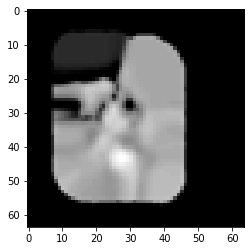

In [0]:
dataset.shape
plt.imshow(dataset[40,:,:,0],'gray')

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
  # i is the present moment, we take past samples from i-history_size (sampled), 
  # then from i onward we take a target_size points for predicted plot 
  # (output/label) or 1 point for single step

In [0]:
# Training and Validation sets (test)

TRAIN_SPLIT = 850 # to change
past_history = 10 # to change
future_target = 1 # to change
STEP = 1          # to change



x_train_multi, y_train_multi = multivariate_data(dataset, labels, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, labels,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,single_step=True)

In [0]:
input_shape = (past_history, input_x, input_y, 1)

In [0]:
BATCH_SIZE =  1 # to channge
BUFFER_SIZE = 10000 # to change

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [0]:
def my_loss(y_actual,y_predicted):
  loss_value =  kb.exp(1-kb.minimum(kb.abs(y_actual),kb.abs(y_predicted)))* kb.square(y_actual-y_predicted)
  return loss_value

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        input_shape = input_shape,
                        padding='same', return_sequences=True))

multi_step_model.add(BatchNormalization())
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        padding='same', return_sequences=True))

multi_step_model.add(BatchNormalization())
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        padding='same', return_sequences=True))

multi_step_model.add(BatchNormalization())
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        padding='same', return_sequences=True))

multi_step_model.add(BatchNormalization())
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        padding='same', return_sequences=True))

multi_step_model.add(BatchNormalization())
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        padding='same', return_sequences=True))

multi_step_model.add(BatchNormalization())
multi_step_model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                        padding='same'))

multi_step_model.add(Conv2D(filters=1, kernel_size=(1, 1),
                        activation='sigmoid',
                        padding='same', data_format='channels_last'))


multi_step_model.compile(loss=my_loss, optimizer='adam')



In [0]:
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 64, 64, 64)    150016    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 64, 64, 64)    256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 64)    295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 64, 64, 64)    256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 64, 64, 64)    295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 64, 64, 64)    256       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 64, 64, 64)    2

In [0]:
for x, y in val_data_multi.take(1):
  out2 = multi_step_model.predict(x)
  print (out2.shape)
  print(y.shape)

(1, 64, 64, 1)
(1, 64, 64, 1)


In [0]:
multi_step_model.load_weights('/content/drive/My Drive/models/CONVLSTM_weights.h5')

In [0]:
EVALUATION_INTERVAL = TRAIN_SPLIT/BATCH_SIZE
EPOCHS = 20


multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=100)

multi_step_model.save_weights('/content/drive/My Drive/models/CONVLSTM_weights.h5')
multi_step_model.save('/content/drive/My Drive/models/CONVLSTM_model.h5')

Epoch 1/20
850/850 [==============================] - 433s 509ms/step - loss: 0.1437 - val_loss: 0.1831
Epoch 2/20
850/850 [==============================] - 440s 518ms/step - loss: 0.1360 - val_loss: 0.1583
Epoch 3/20
850/850 [==============================] - 428s 504ms/step - loss: 0.1355 - val_loss: 0.1573
Epoch 4/20
850/850 [==============================] - 424s 499ms/step - loss: 0.1345 - val_loss: 0.1582
Epoch 5/20
850/850 [==============================] - 432s 508ms/step - loss: 0.1358 - val_loss: 0.1589
Epoch 6/20
850/850 [==============================] - 438s 515ms/step - loss: 0.1467 - val_loss: 0.1980
Epoch 7/20
850/850 [==============================] - 437s 514ms/step - loss: 0.1429 - val_loss: 0.1717
Epoch 8/20
850/850 [==============================] - 435s 512ms/step - loss: 0.1439 - val_loss: 0.1694
Epoch 9/20
238/850 [=======>......................] - ETA: 5:06 - loss: 0.1446

#8



In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

NameError: ignored

(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)
(1, 64, 64, 1)


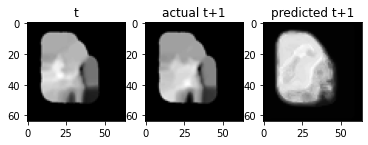

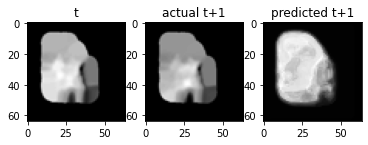

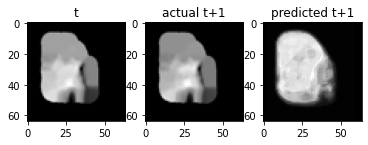

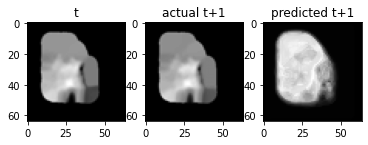

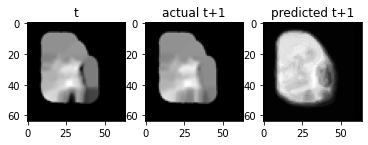

In [0]:
for x, y in val_data_multi.take(5):
  out = multi_step_model.predict(x)
  print(y.shape)
  plt.figure()
  plt.subplot(1,3,1)
  plt.title('t')
  plt.imshow(x[0,9,:,:,0], 'gray')
  plt.subplot(1,3,2)
  plt.title('actual t+1')
  plt.imshow(y[0,:,:,0], 'gray')
  plt.subplot(1,3,3)
  plt.title('predicted t+1')
  plt.imshow(out[0,:,:,0], 'gray')

In [0]:
def draw_seq(dataset,start):
  seq = dataset[start:start+10]
  real = dataset[start+10:start+15]
  pred1 = []
  pred2 = []


  for i in range(5):
    inputs = dataset[start+i:i+start+10]
    inputs = np.expand_dims(inputs, 0)
    pred1.append(multi_step_model.predict(inputs))
  pred1 = np.stack(np.array(pred1))


  inputs = dataset[start:start+10]
  inputs = np.expand_dims(inputs, 0)
  for i in range(5):
    out = multi_step_model.predict(inputs)
    pred2.append(out)
    out = np.expand_dims(out, 0)
    inputs = np.concatenate((inputs[:,1:10],out), axis = 1)
  pred2 = np.stack(np.array(pred2))

  # Plot
  plt.figure()
  plt.title('Past sequence')
  for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(seq[i,:,:,0], 'gray')

  plt.figure()  
  plt.title('Actual Future')
  for i in range(5): 
    plt.subplot(1,5,i+1)
    plt.imshow(real[i,:,:,0], 'gray')

  plt.figure()  
  plt.title('Predicted 1 each sample')
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pred1[i,0,:,:,0], 'gray')

  plt.figure()
  plt.title('Predicted 5 on first sample')
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pred2[i,0,:,:,0], 'gray')
      

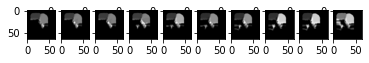

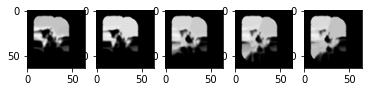

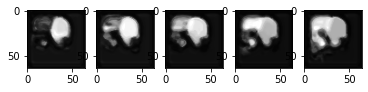

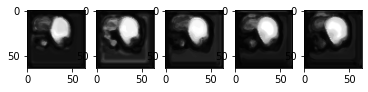

In [0]:
draw_seq(dataset,12)

In [0]:
pred1.shape

(5, 1, 64, 64, 1)